#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
#Если файл открывается с ошибкой, 
#то выполнить эту строку: df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0]), а строку ниже закомментировать
df = pd.read_csv('datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, стоят ли даты в хронологическом порядке

In [4]:
print(df.index.is_monotonic)

True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


## Анализ

Ресеплирование по часу

<AxesSubplot:xlabel='datetime'>

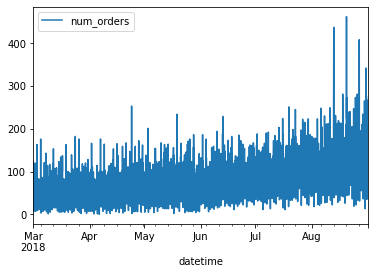

In [6]:
df = df.resample('1H').sum()
df.plot()

<AxesSubplot:xlabel='datetime'>

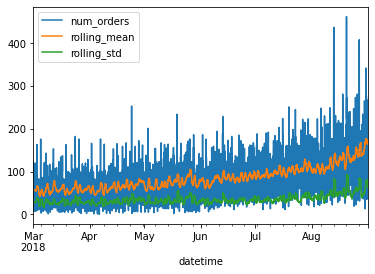

In [7]:
df['rolling_mean'] = df['num_orders'].rolling(24).mean()
df['rolling_std'] = df['num_orders'].rolling(24).std()
df.plot()

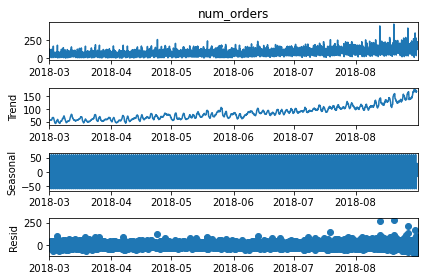

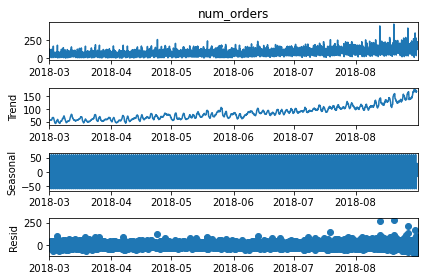

In [8]:
decomposed = seasonal_decompose(df['num_orders'])
decomposed.plot()

<AxesSubplot:title={'center':'Сезонность за 20 дней в августе'}, xlabel='datetime'>

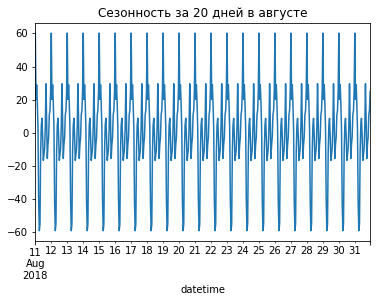

In [9]:
decomposed.seasonal['2018-08-11 00:00:00':'2018-08-31 23:00:00'].plot(title="Сезонность за 20 дней в августе")

<AxesSubplot:title={'center':'Сезонность за сутки 30 августа'}, xlabel='datetime'>

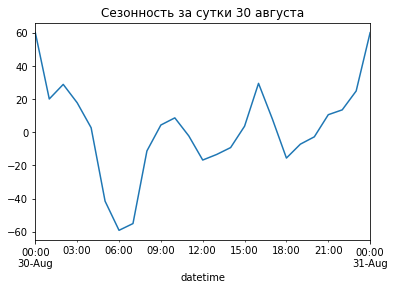

In [10]:
decomposed.seasonal['2018-08-30 00:00:00':'2018-08-31 00:00:00'].plot(title="Сезонность за сутки 30 августа")

<AxesSubplot:title={'center':'Остатки'}, xlabel='datetime'>

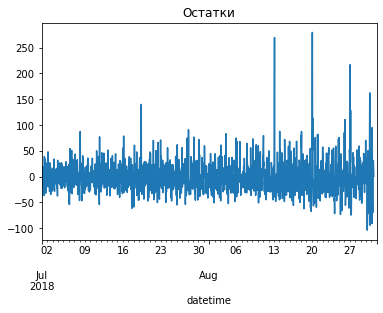

In [11]:
decomposed.resid['2018-07-01 00:00:00':'2018-08-31 23:00:00'].plot(title="Остатки")

<AxesSubplot:title={'center':'Остатки в августе'}, xlabel='datetime'>

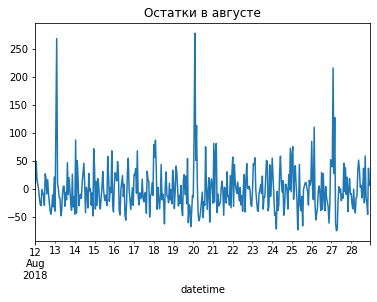

In [12]:
decomposed.resid['2018-08-12 00:00:00':'2018-08-28 23:00:00'].plot(title="Остатки в августе")

<AxesSubplot:title={'center':'Остатки в июле'}, xlabel='datetime'>

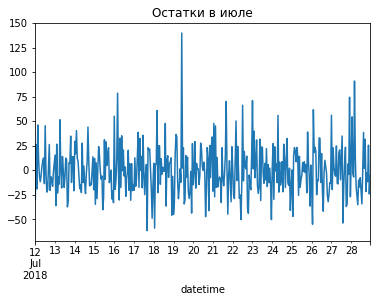

In [13]:
decomposed.resid['2018-07-12 00:00:00':'2018-07-28 23:00:00'].plot(title="Остатки в июле")

<AxesSubplot:title={'center':'Остатки в мае'}, xlabel='datetime'>

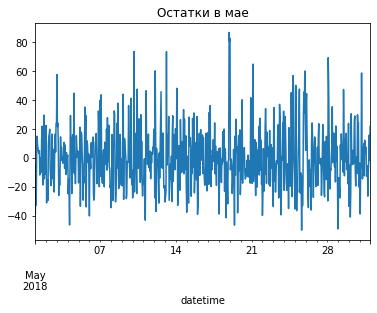

In [14]:
decomposed.resid['2018-05-01 00:00:00':'2018-05-31 23:00:00'].plot(title="Остатки в мае")

**Выводы:**

- чётко прослеживаются пики нагрузки в 23:00-24:00. Сезонность в течение дня.
- общий тренд восходящий
- в остатках есть пики 13, 20, 27 августа, прослеживается связь с днем недели, при этом в предыдущие месяцы такие пики не выявлены

## Обучение

In [15]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    #data['month'] = data.index.month
    #data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data
df = make_features(df,12,24)

In [16]:
df

,num_orders,rolling_mean,rolling_std,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,164.875000,63.268908,19,4,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0,46.0
2018-08-31 20:00:00,154,167.541667,63.105487,20,4,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0,182.0
2018-08-31 21:00:00,159,168.041667,62.801908,21,4,154.0,136.0,207.0,217.0,197.0,116.0,133.0,166.0,136.0,167.0,191.0,203.0


In [17]:
df = df.dropna()

In [18]:
target = df['num_orders']
features = df.drop('num_orders', axis=1)

In [19]:
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1)

In [20]:
print(features_train.index.min(), target_train.index.max())
print(features_test.index.min(), target_test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


### Линейная регрессия

In [21]:
lr = LinearRegression()
tscv = TimeSeriesSplit(n_splits=8)
score_LR = -cross_val_score(lr, features_train, target_train, 
                             scoring='neg_root_mean_squared_error',
                             cv = tscv).mean()
score_LR

31.116071033741676

In [22]:
%time
lr.fit(features_train, target_train)

Wall time: 0 ns


LinearRegression()

### Случайный лес

In [23]:
%%time
rfr = RandomForestRegressor()

parametrs = { 'n_estimators': range (40, 100,20),
              'max_depth': range (2,10, 2)}

grid_RFR = GridSearchCV(rfr, parametrs, cv=tscv,scoring='neg_root_mean_squared_error',verbose=10)
grid_RFR.fit(features_train, target_train)
grid_RFR.best_params_

Fitting 8 folds for each of 12 candidates, totalling 96 fits
[CV 1/8; 1/12] START max_depth=2, n_estimators=40...............................
[CV 1/8; 1/12] END max_depth=2, n_estimators=40;, score=-22.587 total time=   0.0s
[CV 2/8; 1/12] START max_depth=2, n_estimators=40...............................
[CV 2/8; 1/12] END max_depth=2, n_estimators=40;, score=-26.095 total time=   0.0s
[CV 3/8; 1/12] START max_depth=2, n_estimators=40...............................
[CV 3/8; 1/12] END max_depth=2, n_estimators=40;, score=-28.908 total time=   0.0s
[CV 4/8; 1/12] START max_depth=2, n_estimators=40...............................
[CV 4/8; 1/12] END max_depth=2, n_estimators=40;, score=-32.885 total time=   0.1s
[CV 5/8; 1/12] START max_depth=2, n_estimators=40...............................
[CV 5/8; 1/12] END max_depth=2, n_estimators=40;, score=-28.745 total time=   0.1s
[CV 6/8; 1/12] START max_depth=2, n_estimators=40...............................
[CV 6/8; 1/12] END max_depth=2, n_esti

{'max_depth': 8, 'n_estimators': 80}

In [24]:
%%time
grid_RFR.best_estimator_.fit(features_train, target_train)
grid_RFR.best_score_

Wall time: 1.68 s


-24.655678782811684

### Градиентный бустинг LGBMRegressor

В среде яндекса очень долго подбираются параметры, на локальном компьютере наилучшие паmраметры были подобраны следующие:

*best_estimator_* = (max_depth=8, n_estimators=50)

*best_score_* =  23.9416
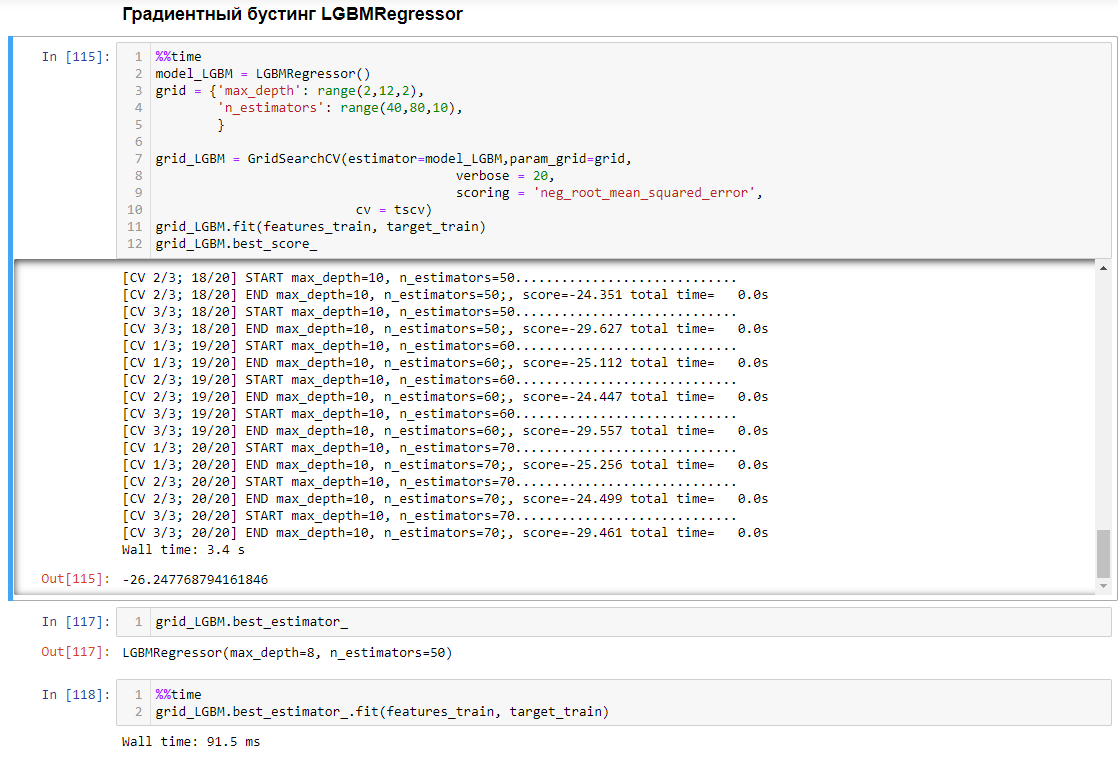

In [25]:
model_LGBM = LGBMRegressor(max_depth=8, n_estimators=50)
score_LR = -cross_val_score(model_LGBM, features_train, target_train, 
                             scoring='neg_root_mean_squared_error',
                             cv = tscv,verbose=10).mean()

[CV] START .....................................................................
[CV] END .............................. score: (test=-20.435) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-21.094) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-22.138) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-24.596) total time=   0.0s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


[CV] START .....................................................................
[CV] END .............................. score: (test=-23.372) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-23.227) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-26.542) total time=   0.0s
[CV] START .....................................................................
[CV] END .............................. score: (test=-30.127) total time=   0.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.4s finished


In [26]:
score_LR

23.941679168198604

**Вывод:** Наименбшую ошибку RMSE на обучающей выборке показала модель LGBMRegressor. 

## Тестирование

In [27]:
model_LGBM.fit(features_train, target_train)
predict_test = model_LGBM.predict(features_test)
print(mean_squared_error(target_test,predict_test)**0.5)

42.54065664173767


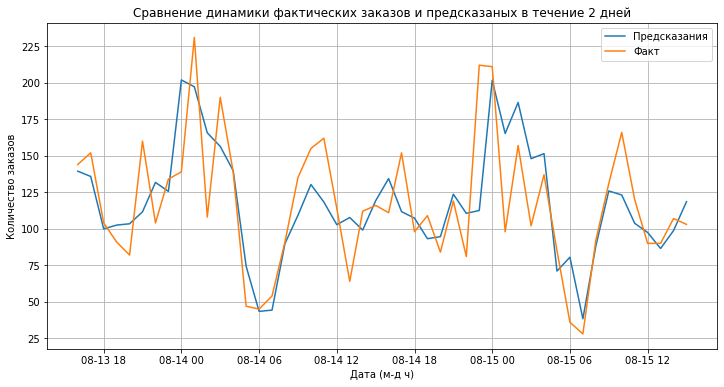

In [28]:
plt.figure(figsize=(12,6))
plt.grid()
plt.plot(features_test[:48].index,predict_test[:48],label="Предсказания")
plt.plot(features_test[:48].index,target_test[:48],label="Факт")
plt.legend()
plt.xlabel("Дата (м-д ч)")
plt.ylabel("Количество заказов")
plt.title("Сравнение динамики фактических заказов и предсказаных в течение 2 дней")
plt.show()